In [16]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import tensorflow as tf
# from models import GenomeMLP
import hyperparameters as hp
import numpy as np
import shap
import pickle
import scanpy as sc
import anndata

from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, f1_score
import pandas as pd


# Sample exploration

In [10]:

adata = sc.read_h5ad("../../antonscode_neurons_with_raw.h5ad")

# adata_masked_raw = adata.raw.X[:, shuffled_indices]
# adata_masked_raw = adata_masked_raw[:, mask]
# adata_masked.raw=anndata.AnnData(X=adata_masked_raw, var=adata.raw.var[mask], obs=adata.obs)


# Filtering out all of the Gm, mt, rik genes.
var_mask = (~adata.var_names.str.contains('Gm')) & \
        (~adata.var_names.str.contains('mt-')) & \
        (~adata.var_names.str.contains('Rik'))

mask = (adata.obs['condition'] == f"adlib30") |\
        (adata.obs['condition'] == f"adlib90")

# Apply the mask to adata (both the main and raw data)
adata_masked = adata[mask, var_mask]
adata_masked.raw = adata.raw.to_adata()[mask, var_mask]


# Create a filtered version of adata.raw
adata = adata_masked
del adata_masked


# reducing the feature space to top 2000 most variable genes
adata.X = adata.raw.X.toarray()
sc.pp.highly_variable_genes(adata, n_top_genes=3000, )
subset_adata = adata[:, adata.var["highly_variable"]]
subset_adata.raw = subset_adata.raw.to_adata()[:, adata.var["highly_variable"]]

final_adata = subset_adata

label_encoder = LabelEncoder()

# encode the data
final_adata.obs['encoded_condition'] = label_encoder.fit_transform(final_adata.obs['condition'] )

del subset_adata
print(final_adata)

# One-hot encode the Leiden clusters
leiden_onehot = pd.get_dummies(final_adata.obs['cell_type_lvl_2'], prefix='leiden')

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2)
reduced_embeddings = umap_model.fit_transform(final_adata.X)




AnnData object with n_obs × n_vars = 27282 × 3000
    obs: 'frac_mito', 'n_counts', 'n_genes', 'replicate', 'condition', 'doublet_score', 'predicted_doublet', 'leiden_res_1.75', 'cell_type_lvl_2', 'encoded_condition'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cell_type_lvl_2_colors', 'condition_colors', 'dendrogram_cell_type_lvl_2', 'hvg', 'leiden_res_1.75', 'leiden_res_1.75_colors', 'neighbors', 'neighbors_harmony', 'pca', 'replicate_colors', 'umap', 'umap_noharmony'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_noharmony'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'neighbors_harmony_connectivities', 'neighbors_harmony_distances'


/users/syu66/.conda/envs/school/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


NameError: name 'cell_types' is not defined

/tmp/ipykernel_1835910/3670354024.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', len(set(cell_conditions)))  # `tab10` is a good colormap for distinct colors


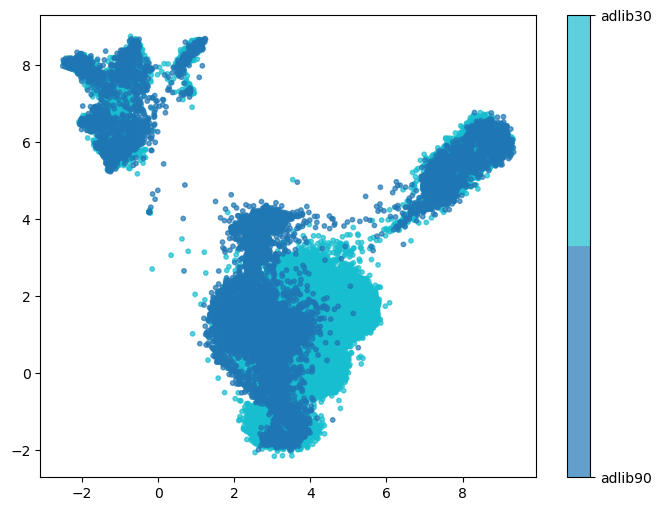

In [20]:
cell_types = final_adata.obs['cell_type_lvl_2'].tolist()
label_encoder = LabelEncoder()
cell_types = label_encoder.fit_transform(cell_types)

cell_conditions = final_adata.obs['encoded_condition']

# Create a discrete colormap (ensuring each cell type has its own color)
colormap = plt.cm.get_cmap('tab10', len(set(cell_conditions)))  # `tab10` is a good colormap for distinct colors

# Create the scatter plot with smaller dots and a distinct color scale for each cell type
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], 
                      c=cell_conditions, cmap=colormap, s=10, alpha=0.7)

# Add a color bar to match colors with labels
# plt.title(f'UMAP of Embeddings: {time} mins, layer {model.layers[i].name}/{len(model.layers)}')

# Optionally, you can add the label names to the color bar:
# color_labels = label_encoder.classes_  # Get the original cell type labels
# cbar = plt.colorbar(scatter)
# cbar.set_ticks(range(len(color_labels)))
# cbar.set_ticklabels(color_labels)

color_labels = final_adata.obs['condition'].unique()
cbar = plt.colorbar(scatter)
cbar.set_ticks(range(len(color_labels)))
cbar.set_ticklabels(color_labels)

plt.show()


In [19]:
np.random.seed(hp.random_seed)
adata = sc.read_h5ad("../../antonscode_neurons_with_raw.h5ad")

# adata_masked_raw = adata.raw.X[:, shuffled_indices]
# adata_masked_raw = adata_masked_raw[:, mask]
# adata_masked.raw=anndata.AnnData(X=adata_masked_raw, var=adata.raw.var[mask], obs=adata.obs)


# Filtering out all of the Gm, mt, rik genes.
var_mask = (~adata.var_names.str.contains('Gm')) & \
        (~adata.var_names.str.contains('mt-')) & \
        (~adata.var_names.str.contains('Rik'))

mask = (adata.obs['condition'] == f"naive30") |\
        (adata.obs['condition'] == f"sucrose30") |\
        (adata.obs['condition'] == f"quinine30") |\
        (adata.obs['condition'] == f"naive90") |\
        (adata.obs['condition'] == f"sucrose90") |\
        (adata.obs['condition'] == f"quinine90")

# Apply the mask to adata (both the main and raw data)
adata_masked = adata[mask, var_mask]
adata_masked.raw = adata.raw.to_adata()[mask, var_mask]


# Create a filtered version of adata.raw
adata = adata_masked
del adata_masked


# reducing the feature space to top 2000 most variable genes
adata.X = adata.raw.X.toarray()
sc.pp.highly_variable_genes(adata, n_top_genes=hp.num_features - 9, )
subset_adata = adata[:, adata.var["highly_variable"]]
subset_adata.raw = subset_adata.raw.to_adata()[:, adata.var["highly_variable"]]

# now splitting out the 30-min time points.
TIME_POINT = "30"
mask = (subset_adata.obs['condition'] == f"naive{TIME_POINT}") |\
    (subset_adata.obs['condition'] == f"sucrose{TIME_POINT}") |\
    (subset_adata.obs['condition'] == f"quinine{TIME_POINT}")

final_adata = subset_adata[mask].copy()

label_encoder = LabelEncoder()

# encode the data
final_adata.obs['encoded_condition'] = label_encoder.fit_transform(final_adata.obs['condition'] )

del subset_adata
print(final_adata)

# One-hot encode the Leiden clusters
leiden_onehot = pd.get_dummies(final_adata.obs['cell_type_lvl_2'], prefix='leiden')

# Ensure leiden_onehot index matches final_adata.obs
leiden_onehot = leiden_onehot.reindex(final_adata.obs.index, fill_value=0)
print(leiden_onehot)

print(len(final_adata.var_names))
new_var = pd.DataFrame(index = list(final_adata.var_names) + list(final_adata.obs['cell_type_lvl_2']))
print(new_var)


AnnData object with n_obs × n_vars = 33058 × 3000
    obs: 'frac_mito', 'n_counts', 'n_genes', 'replicate', 'condition', 'doublet_score', 'predicted_doublet', 'leiden_res_1.75', 'cell_type_lvl_2', 'encoded_condition'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cell_type_lvl_2_colors', 'condition_colors', 'dendrogram_cell_type_lvl_2', 'hvg', 'leiden_res_1.75', 'leiden_res_1.75_colors', 'neighbors', 'neighbors_harmony', 'pca', 'replicate_colors', 'umap', 'umap_noharmony'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_noharmony'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'neighbors_harmony_connectivities', 'neighbors_harmony_distances'
                                leiden_IN_CGE_NPY  leiden_IN_CGE_VIP  \
AAACCCAAGACGCCCT-1-0-sucrose30              False               True   
AAACCCACACCCTTGT-1-0-sucrose30              False              False   
AAACCCATCCCAAGCG-1-0-sucr

In [25]:
# Concatenate matrix
print(leiden_onehot.shape)
data = np.hstack((final_adata.X, leiden_onehot))
print(data.shape)
# Ensure var is a DataFrame
var_names = list(final_adata.var_names) + ["leiden_IN_CGE_NPY", "leiden_IN_CGE_VIP", "leiden_IN_MGE-Pvalb",  "leiden_IN_MGE-SST", "leiden_Pyrlayer2a/b", "leiden_Pyrlayer3", "leiden_SL1",  "leiden_SL2",  "leiden_Vglut2"]  

var_df = pd.DataFrame(index=var_names)  
print(final_adata.var_names)
print(final_adata.obs['cell_type_lvl_2'].unique())


# Construct new AnnData object
final_adata = anndata.AnnData(
    X=data, 
    var=var_df, 
    obs=final_adata.obs, 
    uns=final_adata.uns, 
    obsm=final_adata.obsm
)

# Ensure 'encoded_condition' is categorical
final_adata.obs['encoded_condition'] = final_adata.obs['encoded_condition'].astype(str)

# Split the dataset
train_idx, test_idx = train_test_split(
    range(final_adata.n_obs),
    test_size=0.20,
    random_state=hp.random_seed, 
    stratify=final_adata.obs['encoded_condition']
)

(33058, 9)
(33058, 3018)
Index(['Rgs20', 'St18', 'Vxn', 'Snhg6', 'Cpa6', 'Prex2', 'Sulf1', 'Eya1',
       'Crispld1', 'Pkhd1',
       ...
       'AC149090.1', 'IN_CGE_VIP', 'Pyrlayer3', 'Pyrlayer2a/b', 'Vglut2',
       'IN_MGE-SST', 'SL2', 'IN_CGE_NPY', 'IN_MGE-Pvalb', 'SL1'],
      dtype='object', length=3009)
['IN_CGE_VIP', 'Pyrlayer3', 'Pyrlayer2a/b', 'Vglut2', 'IN_MGE-SST', 'SL2', 'IN_CGE_NPY', 'IN_MGE-Pvalb', 'SL1']
Categories (9, object): ['IN_CGE_NPY', 'IN_CGE_VIP', 'IN_MGE-Pvalb', 'IN_MGE-SST', ..., 'Pyrlayer3', 'SL1', 'SL2', 'Vglut2']


In [8]:
! pwd
np.random.seed(hp.random_seed)
adata = sc.read_h5ad("../../antonscode_neurons_with_raw.h5ad")
# adata = sc.read_h5ad("../../neurons.h5ad")
#
print(adata)
# adata_masked_raw = adata.raw.X[:, shuffled_indices]
# adata_masked_raw = adata_masked_raw[:, mask]
# adata_masked.raw=anndata.AnnData(X=adata_masked_raw, var=adata.raw.var[mask], obs=adata.obs)

# Filtering out all of the Gm, mt, rik genes.
var_mask = (~adata.var_names.str.contains('Gm')) & \
        (~adata.var_names.str.contains('mt-')) & \
        (~adata.var_names.str.contains('Rik'))



# Apply the mask to adata (both the main and raw data)
adata_masked = adata[:, var_mask]
adata_masked.raw = adata.raw.to_adata()[:, var_mask]


# Create a filtered version of adata.raw
adata = adata_masked
del adata_masked

print("finished masking")

sc.pp.highly_variable_genes(adata, n_top_genes=hp.num_features - 6, )
full_highly_variable = adata[:, adata.var["highly_variable"]]
full_highly_variable = full_highly_variable.var.index

print(adata)

# reducing the feature space to top 3000 most variable genes
adata.X = adata.raw.X.toarray()
sc.pp.highly_variable_genes(adata, n_top_genes=hp.num_features, )
subset_adata = adata[:, adata.var["highly_variable"]]
subset_adata.raw = subset_adata.raw.to_adata()[:, adata.var["highly_variable"]]
print(subset_adata)

/oscar/home/syu66/Documents/singh_research/mlp_timepoints/notebooks
AnnData object with n_obs × n_vars = 103987 × 17089
    obs: 'frac_mito', 'n_counts', 'n_genes', 'replicate', 'condition', 'doublet_score', 'predicted_doublet', 'leiden_res_1.75', 'cell_type_lvl_2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cell_type_lvl_2_colors', 'condition_colors', 'dendrogram_cell_type_lvl_2', 'hvg', 'leiden_res_1.75', 'leiden_res_1.75_colors', 'neighbors', 'neighbors_harmony', 'pca', 'replicate_colors', 'umap', 'umap_noharmony'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_noharmony'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'neighbors_harmony_connectivities', 'neighbors_harmony_distances'
finished masking
AnnData object with n_obs × n_vars = 103987 × 14050
    obs: 'frac_mito', 'n_counts', 'n_genes', 'replicate', 'condition', 'doublet_score', 'predicted_doublet', 'leiden_res_1.

In [9]:
time_point = "90"
def make_mask(time_point):
    return (subset_adata.obs['condition'] == f"naive{time_point}") |\
        (subset_adata.obs['condition'] == f"sucrose{time_point}") |\
        (subset_adata.obs['condition'] == f"quinine{time_point}")

thirty = adata[make_mask("30")].copy()
sc.pp.highly_variable_genes(thirty, n_top_genes=3000, )
thirty = thirty[:, thirty.var['highly_variable']]

ninety = adata[make_mask("90")].copy()
sc.pp.highly_variable_genes(ninety, n_top_genes=3000, )
ninety = ninety[:, ninety.var['highly_variable']]

thirty_and_ninety = adata[(make_mask("30") | make_mask("90"))].copy()
sc.pp.highly_variable_genes(thirty_and_ninety, n_top_genes=3000, )
thirty_and_ninety = thirty_and_ninety[:, thirty_and_ninety.var['highly_variable']]





In [17]:
print(adata.obs["cell_type_lvl_2"].unique())
adata.obs['leiden_res_1.75']

# 'Pyrlayer2a/b': [4,6],
#     'Pyrlayer3': [0,1,2,3,5,8,9,11],
#     'Semilunar1': [12],
#     'Semilunar2': [7,19],
#     'IN-CGE-VIP': [18],
#     'IN-MGE-SST': [13,14],
#     'IN-MGE-Pvalb': [15],
#     'IN-CGE-NPY': [16,17],
#     'Vglut2':[10,20]

# differentially expressed genes (degs): genes that differentiate cell types from other cell types
# core question: within each cell type, how similar are these cell types based on their gene expression during learning and 
# what is the similarity of the cell types in each condition and how does this similarity change with learning? 
# ie within semilunar cells does gene expression change betwween naive and sucrose because semilunar cells are plastic...?

# comparing cell types between naive and sucrose for iegs

# cell type: 

# semilunar cells are less plastic because they're just picking up smells...?

# 2ab and 3 cells should be more plastic ith learning because they're interacting with higher order cells (prefrontal cortex) 
# expected that odor learning is stored in these cells in the form of gene expression profile
# within naive there's a gene profile and within sucrose there's hhypothesiesed to be a different profile to reflect the learning that's 
# occurred

# inhibitory cells are expected to be very plastic and their gene profile would also change between 30naive and 30sucrose and same with 90
# 90 navie and 90sucrose. genes that are expressed at 30 are driving what is changing with genes that are changing at 90
# if naive and sucrose are different at 30, then it's expected that 90 sucrose would be very different from 30 sucrose. it's expected
# that this would be very cell type specific. 
# inhibitory cells would inhibit the pyramidal cells, and create circuits within the piriform 


# activity dependnet genes, recurrent networks in the piriform, association in the piriform






['Pyrlayer3', 'Vglut2', 'SL1', 'IN_MGE-SST', 'IN_MGE-Pvalb', 'Pyrlayer2a/b', 'IN_CGE_NPY', 'IN_CGE_VIP', 'SL2']
Categories (9, object): ['IN_CGE_NPY', 'IN_CGE_VIP', 'IN_MGE-Pvalb', 'IN_MGE-SST', ..., 'Pyrlayer3', 'SL1', 'SL2', 'Vglut2']


AAACCCAAGAGGTCAC-1-0-sucrose90     0
AAACCCACACATGTTG-1-0-sucrose90     2
AAACCCACATTCTCTA-1-0-sucrose90     2
AAACCCAGTCCGCAGT-1-0-sucrose90     1
AAACCCATCCGAAGGA-1-0-sucrose90    10
                                  ..
TTTGGTTCATAGACTC-1-2-bored         2
TTTGGTTGTACGACAG-1-2-bored        12
TTTGGTTGTCCTGGGT-1-2-bored         7
TTTGTTGAGCCAAGTG-1-2-bored         2
TTTGTTGTCATGAGAA-1-2-bored         8
Name: leiden_res_1.75, Length: 103987, dtype: category
Categories (22, object): ['0', '1', '2', '3', ..., '18', '19', '20', '21']

Index(['St18', 'Vxn', 'Cpa6', 'Prex2', 'Sulf1', 'Crispld1', 'Paqr8', 'Tram2',
       'Kcnq5', 'B3gat2',
       ...
       'Nhs', 'Ap1s2', 'Vegfd', 'Glra2', 'Egfl6', 'Frmpd4', 'Msl3', 'Arhgap6',
       'Spry3', 'AC149090.1'],
      dtype='object', length=3000)
Index(['Rgs20', 'Oprk1', 'St18', 'Vxn', 'Mybl1', 'Snhg6', 'Cpa6', 'Prex2',
       'Sulf1', 'Eya1',
       ...
       'Nhs', 'Glra2', 'Trappc2', 'Tceanc', 'Tlr7', 'Frmpd4', 'Arhgap6',
       'Hccs', 'Spry3', 'AC149090.1'],
      dtype='object', length=3000)
Index(['St18', 'Slco5a1', 'Msc', 'Trpa1', 'Sbspon', 'Rdh10', 'Tfap2d', 'Tram2',
       'Tmem14a', 'Sdhaf4',
       ...
       'Sat1', 'Prdx4', 'Rs1', 'Ap1s2', 'Siah1b', 'Gemin8', 'Trappc2', 'Prps2',
       'Msl3', 'Asmt'],
      dtype='object', length=3000)
View of AnnData object with n_obs × n_vars = 84069 × 3000
    obs: 'frac_mito', 'n_counts', 'n_genes', 'replicate', 'condition', 'leiden', 'leiden_noharmony', 'leiden_harmony'
    var: 'gene_ids', 'feature_types', 'n_cells-0-

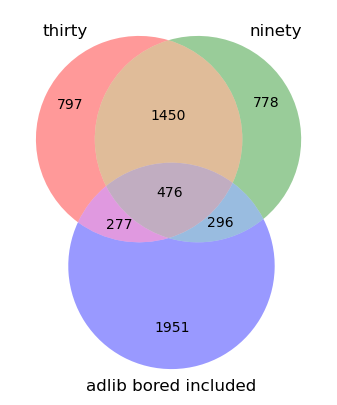

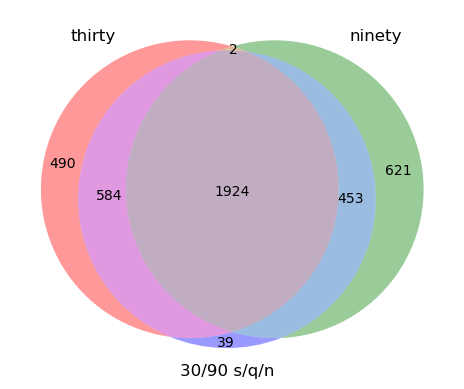

CSV saved as overlapping_highly_variable.csv


In [7]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

print(thirty.var.index)
print(ninety.var.index)
print(full_highly_variable)
print(thirty_and_ninety)
# Convert to sets
set1 = set(thirty.var.index)
set2 = set(ninety.var.index)
set3 = set(full_highly_variable)
set4 = set(thirty_and_ninety.var.index)

# Create Venn diagram
plt.figure(figsize=(5,5))
venn3([set1, set2, set3], ('thirty', 'ninety', 'adlib bored included'))

# Show the plot
plt.show()

venn3([set1, set2, set4], ('thirty', 'ninety', '30/90 s/q/n'))
plt.show()

# Compute the unique and common elements
only_in_index1 = sorted(set1 - set2)
only_in_index2 = sorted(set2 - set1)
in_both = sorted(set1 & set2)

# Create a DataFrame
max_len = max(len(only_in_index1), len(only_in_index2), len(in_both))
data = {
    "Only in Index 1": only_in_index1 + [''] * (max_len - len(only_in_index1)),
    "Only in Index 2": only_in_index2 + [''] * (max_len - len(only_in_index2)),
    "In Both": in_both + [''] * (max_len - len(in_both)),
}

df = pd.DataFrame(data)

# Save to CSV
# csv_filename = "overlapping_highly_variable.csv"
df.to_csv(csv_filename, index=False)

print(f"CSV saved as {csv_filename}")

# Sample + IEG exploration

View of AnnData object with n_obs × n_vars = 61895 × 3006
    obs: 'frac_mito', 'n_counts', 'n_genes', 'replicate', 'condition', 'doublet_score', 'predicted_doublet', 'leiden_res_1.75', 'cell_type_lvl_2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cell_type_lvl_2_colors', 'condition_colors', 'dendrogram_cell_type_lvl_2', 'hvg', 'leiden_res_1.75', 'leiden_res_1.75_colors', 'neighbors', 'neighbors_harmony', 'pca', 'replicate_colors', 'umap', 'umap_noharmony'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_noharmony'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'neighbors_harmony_connectivities', 'neighbors_harmony_distances'


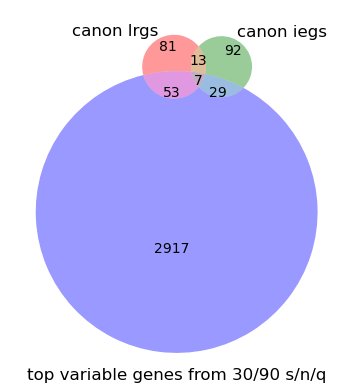

In [19]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
lrgs = [
    "Fndc9", "Meox1","Scg2", "Kcnj4","Glt28d2", "Gpr3","Mbnl2", "Trip10","Maml3", "Cd109","Csrnp1", "Gpr63","Sv2c", "Tll1","Hsd17b12", "Bmp3","Crhbp", "Stc1","Col10a1", "Klhl4","Gch1", "Sostdc1","Tac1", "Spred3","Errfi1", "Sowahb","C2cd4b", "Slitrk4","Prok2", "Mfap3l","Slc2a3", "Kcna1","Cartpt", "Fezf2","Kcnj3", "Dennd2c","Chrm2", "Stc2","Mlf1", "Hdac9", "Dusp4", "Hunk","Popdc3", "Pthlh","Ccdc184", "Pnoc","Dusp14", "Kcnh8","Kcnf1", "Acan","Alpk1", "Gper1","Rgs2", "Omg","Wdr90", "Chac1","Grasp", "Stac","Coq10b", "Nptx2","Fam126b", "Kcna4","Mctp2", "Sema3e","Bdnf", "Palmd", "Gem", "Rab39","Tiparp", "Serpinb2","Gpr22", "Hspb3","Pcsk1", "5430416O09Rik","Cystm1", "9430020K01Rik","Ptgs2", "Dmxl1", "Per1", "Cdkn1a", "Ptger4", "Fbxo33", "Adm", "Sik1","Pax1", "Crem","Pou3f1", "Spty2d1","Chst8", "Tbc1d8b","Pgap1", "Zdbf2","Lipg", "Bves", "Adcyap1", "Chml","Slc7a1", "Klf14", "Pcdh8", "Rgs4", "Areg", "Rnf128","Nap1l5", "Peg10","Tnn", "Nr4a3","Stk40", "Atp10d","Rel", "Slc6a17","Slc40a1", "Mthfd2","Brinp1", "Nrn1","Per2", "Msantd1","Rem2", "Gprc5a","Eprs", "Pam","Sertad1", "Tacr3","Hcrtr2", "Herpud1","Stard4", "Nppc","Pard6a", "Plagl1","Pcdh20", "Osgin2","Mpp7", "Kcns2","Cort", "Sstr2","Ell2", "Gpr26","Sult2b1", "Rheb","Acsl4", "Nr4a2","Nefl", "Fosl2","Tec", "Fam46a","Gmeb2", "Rasgrp1", "Gltscr2", "Atf3", "Kitl", "Baz1a", "Npbwr1", "4931440P22Rik", "Cfap43", "D16Ertd472e"
]
iegs = [
    "Fos", "Fosb", "Fosl1", "Fosl2", "Jun", "Junb", "Jund", "Egr1", "Egr2", "Egr3", "Egr4",
    "Nr4a1", "Nr4a2", "Nr4a3", "Arc", "Homer1", "Rheb", "Rgs2", "Plk2", "Ptgs2", "Bdnf", "Inhba",
    "Nptx2", "Plat", "Nrn1", "Myc", "Dusp1", "Dusp5", "Dusp6", "Pcdh8", "Cyr61", "Gadd45b",
    "Trib1", "Gem", "Btg2", "Ier2", "Npas4", "Rasd1", "Crem", "Mbnl2", "Arf4", "Gadd45g", "Arih1",
    "Nup98", "Ppp1r15a", "Fbxo33", "Per1", "Per2", "Maff", "Zfp36", "Srf", "Mcl1", "Ctgf", "Il6",
    "Atf3", "Rcan1", "Ncoa7", "Cxcl2", "Bhlhe40", "Slc2a3", "Nfkbia", "Ier3", "Sgk1", "Klf6",
    "Klf10", "Nfkbiz", "Flg", "Gbp2b", "Tnfaip3", "Cebpd", "Hbegf", "Ldlr", "Tsc22d1", "F3",
    "Ccl2", "Csrnp1", "Pmaip1", "Zfp36l2", "Plau", "Ccl5", "Saa3", "Ifnb1", "Tnf", "Irf1",
    "Cd83", "Map3k8", "Socs3", "Csf2", "Il1a", "Cxcl1", "Il12b", "Il1b", "Sod2", "Pim1",
    "Peli1", "Tlr2", "Ccl3", "Noct", "Bcl3", "Ifit2", "Icam1", "Ifit1", "Tnfsf9", "Ccrl2",
    "Cxcl10", "Gbp2", "Il10", "Clec4e", "Acod1", "Mmp13", "Cxcl11", "Il23a", "Arhgef3",
    "Serpine1", "Traf1", "Vcam1", "Ackr4", "Marcksl1", "Nfkbid", "Ikbke", "Ccl12", "Ifit3",
    "Cebpb", "Zfp36l1", "Txnip", "Nfib", "Hes1", "Pias1", "Klf2", "Cd69", "Dusp2", "Wee1",
    "Thbs1", "Sik1", "Gdf15", "Ier5", "Rgs1", "Id2", "Apold1", "Egr4", "Fosb", "Npas4",
    "Fos", "Btg2", "Ier2", "Amigo3", "Egr3", "Dusp1", "Klf4", "Arc", "Gadd45g", "Ppp1r15a",
    "Egr2", "Dusp5", "Maff", "Junb", "Nr4a1", "Egr1"
]

lrgs = set(lrgs)
iegs = set(iegs)
print(thirty_and_ninety)

venn3([lrgs, iegs, set(thirty_and_ninety.var.index)], ('canon lrgs', 'canon iegs', 'top variable genes from 30/90 s/n/q'))

# Show the plot
plt.show()

# Model exploration

In [1]:
import h5py
from sklearn.model_selection import train_test_split
# import hyperparameters as hp
import numpy as np
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

import shap.maskers
from keras.models import load_model
# import hyperparameters as hp
import numpy as np
import shap
import pickle
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap



2025-04-08 15:06:50.504777: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-08 15:06:51.940237: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class MaxScaler(tf.keras.Layer):
    def call(self, inputs):
        max_val = tf.reduce_max(inputs, axis=1, keepdims=True)
        return max_val * 4

# m30 = load_model(f"../ct-models/30min-model.h5", custom_objects={"MaxScaler": MaxScaler})
# m90 = load_model(f"../ct-models/90min-model.h5", custom_objects={"MaxScaler": MaxScaler})

m30 = load_model(f"../ct-models/30min-model.h5")
m90 = load_model(f"../ct-models/90min-model.h5")

mods = ["IN_CGE_NPY", "IN_CGE_VIP", "IN_MGE-Pvalb",  "IN_MGE-SST", "Pyrlayer2a/b", "Pyrlayer3", "SL1",  "SL2",  "Vglut2"]

def read_data(time):
    with open(f'../pickles/{time}min-data/train_data.pkl', 'rb') as f:
        m30_train = pickle.load(f)
    with open(f'../pickles/{time}min-data/train_labels.pkl', 'rb') as f:
        m30_obs_train = pickle.load(f)
    with open(f'../pickles/{time}min-data/test_data.pkl', 'rb') as f:
        m30_test = pickle.load(f)
    with open(f'../pickles/{time}min-data/test_labels.pkl', 'rb') as f:
        m30_obs_test = pickle.load(f)
        
    return m30_train, m30_obs_train, m30_test, m30_obs_test
data = {}
for time in ["30", "90"]:
    data[time] = read_data(time)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input2 (InputLayer) │ (None, 9)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input1 (InputLayer) │ (None, 3000)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1070)      │     10,700 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_i2      │ (None, 4070)      │          0 │ input1[0][0],     │
│ (Concatenate)       │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1024)      │  4,168,704 │ concatenate_i2[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1024)      │  1,049,600 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 640)       │    656,000 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │     82,048 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 3)         │        387 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,967,441 (22.76 MB)

 Trainable params: 5,967,439 (22.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

<InputLayer name=input2, built=True>
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step


/users/syu66/.conda/envs/school/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input1', 'input2']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/users/syu66/.conda/envs/school/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/tmp/ipykernel_1835910/2428279979.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', len(set(cell_types)))  # `tab10` is a good colormap for distinct colors


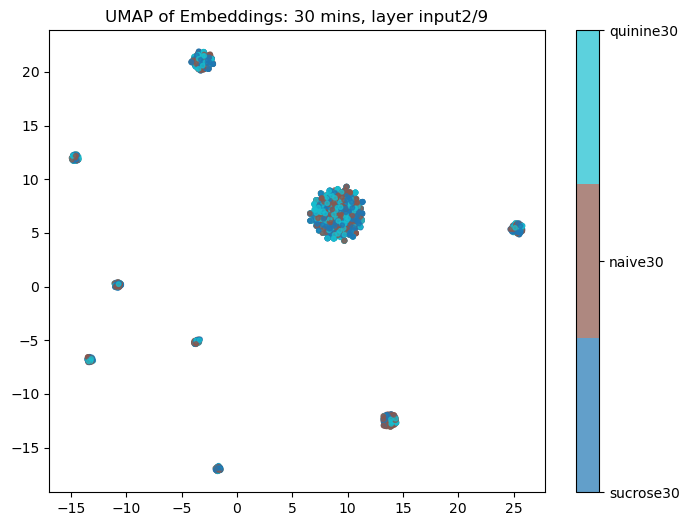

<InputLayer name=input1, built=True>
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step


/users/syu66/.conda/envs/school/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input1', 'input2']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/users/syu66/.conda/envs/school/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/tmp/ipykernel_1835910/2428279979.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', len(set(cell_types)))  # `tab10` is a good colormap for distinct colors


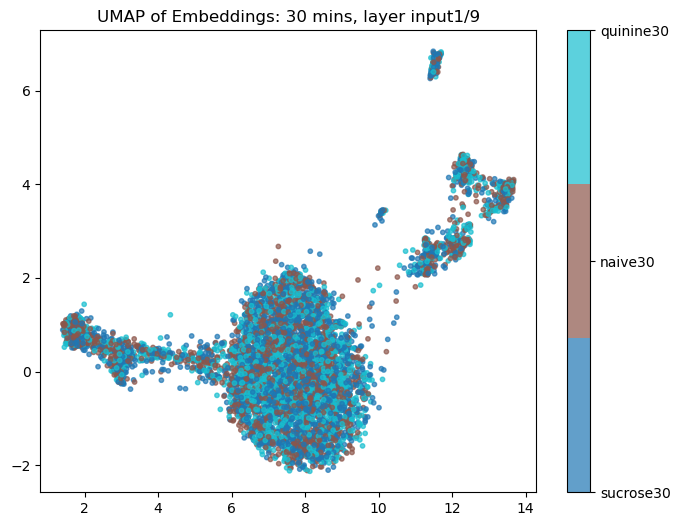

<Dense name=dense_6, built=True>
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step


/users/syu66/.conda/envs/school/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input1', 'input2']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/users/syu66/.conda/envs/school/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/tmp/ipykernel_1835910/2428279979.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', len(set(cell_types)))  # `tab10` is a good colormap for distinct colors


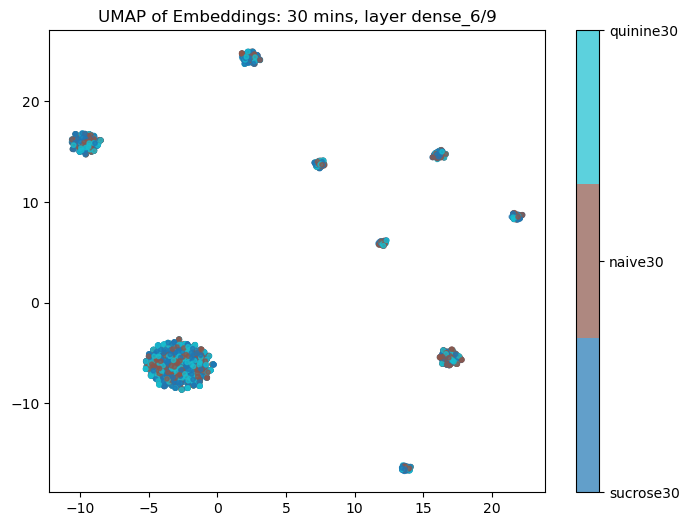

<Concatenate name=concatenate_i2, built=True>
175/207 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step

/users/syu66/.conda/envs/school/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input1', 'input2']. Received: the structure of inputs=('*', '*')
  warnings.warn(


207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step


/users/syu66/.conda/envs/school/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/tmp/ipykernel_1835910/2428279979.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', len(set(cell_types)))  # `tab10` is a good colormap for distinct colors


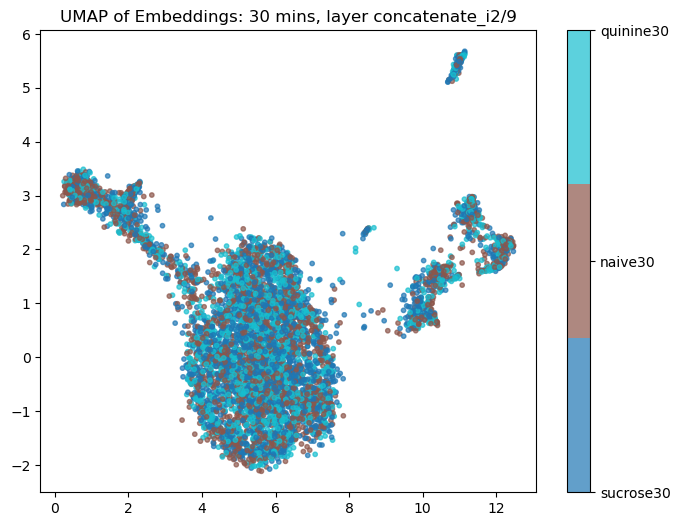

<Dense name=dense_7, built=True>
 51/207 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

/users/syu66/.conda/envs/school/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input1', 'input2']. Received: the structure of inputs=('*', '*')
  warnings.warn(


207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/users/syu66/.conda/envs/school/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/tmp/ipykernel_1835910/2428279979.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', len(set(cell_types)))  # `tab10` is a good colormap for distinct colors


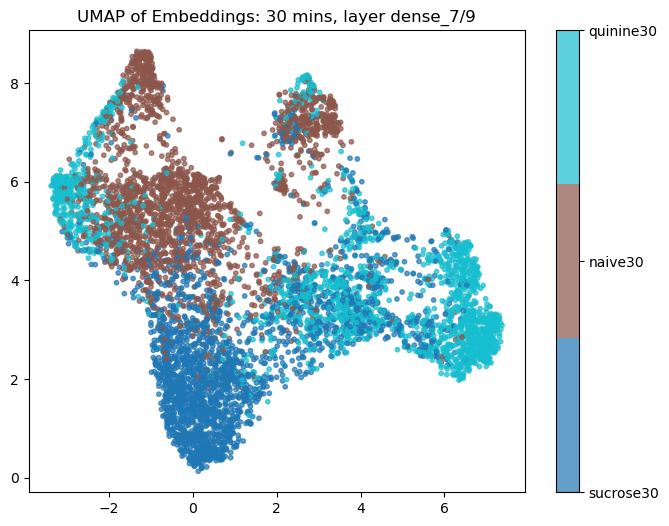

<Dense name=dense_8, built=True>
 31/207 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

/users/syu66/.conda/envs/school/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input1', 'input2']. Received: the structure of inputs=('*', '*')
  warnings.warn(


207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/users/syu66/.conda/envs/school/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/tmp/ipykernel_1835910/2428279979.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', len(set(cell_types)))  # `tab10` is a good colormap for distinct colors


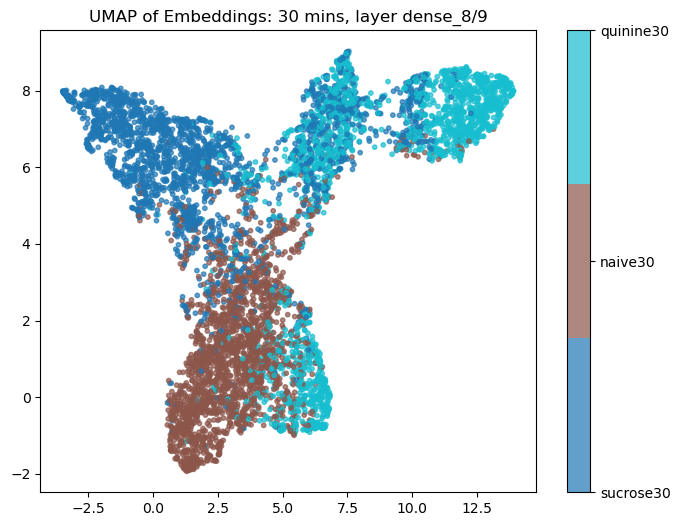

<Dense name=dense_9, built=True>
 33/207 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

/users/syu66/.conda/envs/school/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input1', 'input2']. Received: the structure of inputs=('*', '*')
  warnings.warn(


207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/users/syu66/.conda/envs/school/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/tmp/ipykernel_1835910/2428279979.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', len(set(cell_types)))  # `tab10` is a good colormap for distinct colors


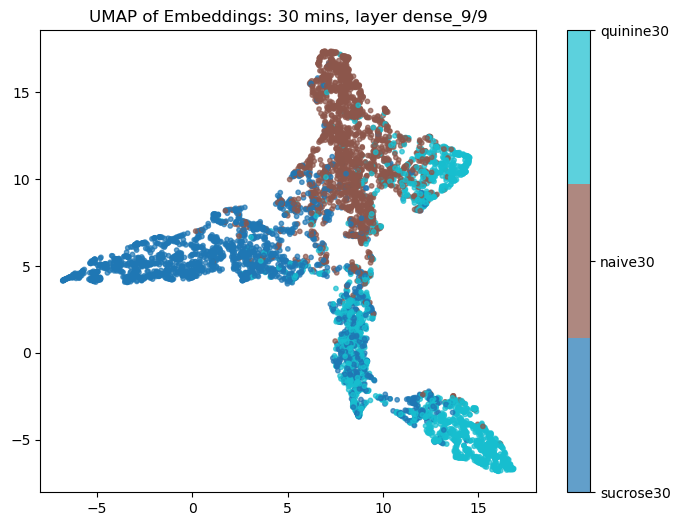

<Dense name=dense_10, built=True>
 32/207 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

/users/syu66/.conda/envs/school/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input1', 'input2']. Received: the structure of inputs=('*', '*')
  warnings.warn(


207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/users/syu66/.conda/envs/school/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/tmp/ipykernel_1835910/2428279979.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', len(set(cell_types)))  # `tab10` is a good colormap for distinct colors


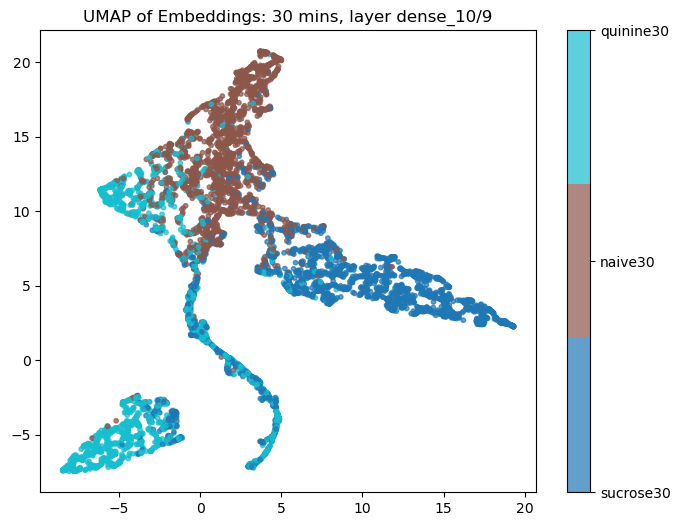

<Dense name=dense_11, built=True>
 33/207 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

/users/syu66/.conda/envs/school/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input1', 'input2']. Received: the structure of inputs=('*', '*')
  warnings.warn(


207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/users/syu66/.conda/envs/school/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/tmp/ipykernel_1835910/2428279979.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', len(set(cell_types)))  # `tab10` is a good colormap for distinct colors


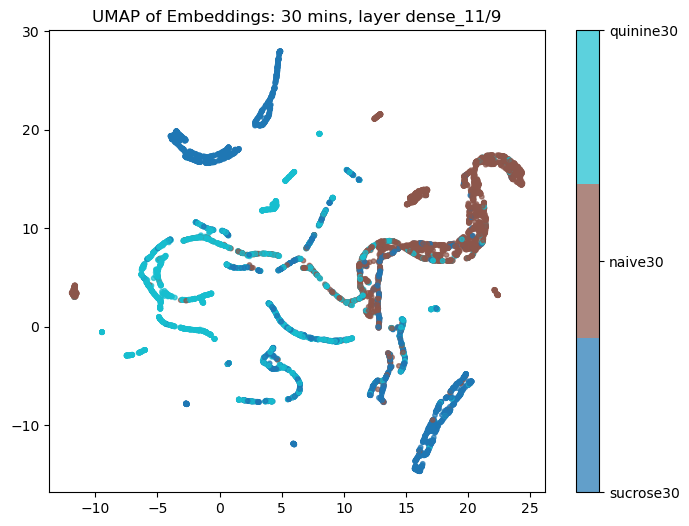

In [22]:
def visualize_layer(model,  time):
    for i in range(len(model.layers)):
        print(model.layers[i])
        m = tf.keras.models.Model(inputs=model.input, outputs=model.layers[i].output)
        m_embedding = m.predict((data[time][2][0].X.toarray(), data[time][2][1].astype(np.float32)))

        # cell_types = data[time][2][0].obs['cell_type_lvl_2'].tolist()
        # label_encoder = LabelEncoder()
        # cell_types = label_encoder.fit_transform(cell_types)

        cell_types = data[time][2][0].obs['encoded_condition']
        
        # Apply UMAP for dimensionality reduction
        umap_model = umap.UMAP(n_components=2)
        reduced_embeddings = umap_model.fit_transform(m_embedding)
        
        
        # Create a discrete colormap (ensuring each cell type has its own color)
        colormap = plt.cm.get_cmap('tab10', len(set(cell_types)))  # `tab10` is a good colormap for distinct colors
        
        # Create the scatter plot with smaller dots and a distinct color scale for each cell type
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], 
                              c=cell_types, cmap=colormap, s=10, alpha=0.7)
        
        # Add a color bar to match colors with labels
        plt.title(f'UMAP of Embeddings: {time} mins, layer {model.layers[i].name}/{len(model.layers)}')
        
        # Optionally, you can add the label names to the color bar:
        # color_labels = label_encoder.classes_  # Get the original cell type labels
        color_labels = data[time][2][0].obs['condition'].unique()
        cbar = plt.colorbar(scatter)
        cbar.set_ticks(range(len(color_labels)))
        cbar.set_ticklabels(color_labels)
        
        plt.show()

m30.summary()
visualize_layer(m30, "30")


In [7]:
# Get the penultimate layer (second-to-last layer)
m30_2 = tf.keras.models.Model(inputs=m30.input, outputs=m30.layers[0].output)
m30_embedding = m30_2.predict((data["30"][2][0].X.toarray(), data["30"][2][1].astype(np.float32)))
# Predict embeddings for your data
m90_2 = tf.keras.models.Model(inputs=m90.input, outputs=m90.layers[0].output)
m90_embedding = m90_2.predict((data["90"][2][0].X.toarray(), data["90"][2][1].astype(np.float32)))

# Get the penultimate layer (second-to-last layer)
# m30_2 = tf.keras.models.Model(inputs=m30.input, outputs=m30.layers[-2].output)
# m30_embedding = m30_2.predict(data["30"][2][0].X.toarray(),)
# # Predict embeddings for your data
# m90_2 = tf.keras.models.Model(inputs=m90.input, outputs=m90.layers[-2].output)
# m90_embedding = m90_2.predict(data["90"][2][0].X.toarray())


207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step


/users/syu66/.conda/envs/school/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input1', 'input2']. Received: the structure of inputs=('*', '*')
  warnings.warn(


181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step


/users/syu66/.conda/envs/school/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input1', 'input2']. Received: the structure of inputs=('*', '*')
  warnings.warn(


/users/syu66/.conda/envs/school/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/tmp/ipykernel_1288692/2941354765.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', len(set(cell_types)))  # `tab10` is a good colormap for distinct colors


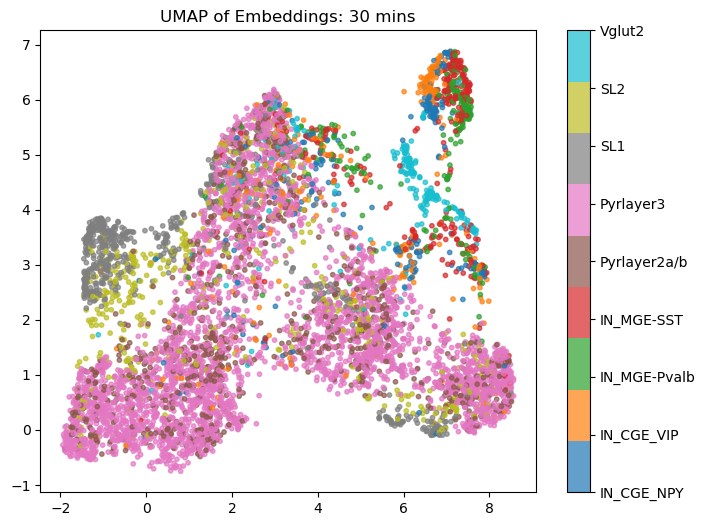

/users/syu66/.conda/envs/school/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/tmp/ipykernel_1288692/2941354765.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', len(set(cell_types)))  # `tab10` is a good colormap for distinct colors


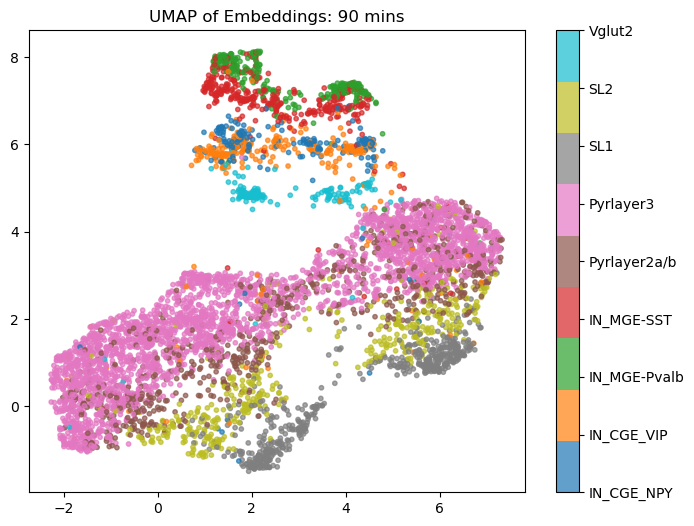

In [6]:


cell_types = data["30"][2][0].obs['cell_type_lvl_2'].tolist()
label_encoder = LabelEncoder()
cell_types = label_encoder.fit_transform(cell_types)

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2)
reduced_embeddings = umap_model.fit_transform(m30_embedding)


# Create a discrete colormap (ensuring each cell type has its own color)
colormap = plt.cm.get_cmap('tab10', len(set(cell_types)))  # `tab10` is a good colormap for distinct colors

# Create the scatter plot with smaller dots and a distinct color scale for each cell type
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], 
                      c=cell_types, cmap=colormap, s=10, alpha=0.7)

# Add a color bar to match colors with labels
plt.title('UMAP of Embeddings: 30 mins')

# Optionally, you can add the label names to the color bar:
color_labels = label_encoder.classes_  # Get the original cell type labels
cbar = plt.colorbar(scatter)
cbar.set_ticks(range(len(color_labels)))
cbar.set_ticklabels(color_labels)

plt.show()

##########################################################################################
##########################################################################################
##########################################################################################
##########################################################################################

cell_types = data["90"][2][0].obs['cell_type_lvl_2'].tolist()
label_encoder = LabelEncoder()
cell_types = label_encoder.fit_transform(cell_types)

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2)
reduced_embeddings = umap_model.fit_transform(m90_embedding)


# Create a discrete colormap (ensuring each cell type has its own color)
colormap = plt.cm.get_cmap('tab10', len(set(cell_types)))  # `tab10` is a good colormap for distinct colors

# Create the scatter plot with smaller dots and a distinct color scale for each cell type
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], 
                      c=cell_types, cmap=colormap, s=10, alpha=0.7)

# Add a color bar to match colors with labels
plt.title('UMAP of Embeddings: 90 mins')

# Optionally, you can add the label names to the color bar:
color_labels = label_encoder.classes_  # Get the original cell type labels
cbar = plt.colorbar(scatter)
cbar.set_ticks(range(len(color_labels)))
cbar.set_ticklabels(color_labels)

plt.show()



In [10]:
with open("embedding_output.txt", "w") as f:
    f.write(str(m30_embedding))

data["30"][2][0].X.toarray().shape

m30_embedding

print(max([max(cell) for cell in m30_embedding]))



43.11631
